In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
from itertools import chain
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wrg 
wrg.filterwarnings('ignore')

##Import any other packages you may need here
from pydicom import dcmread
from skimage import io
from skimage.io import imread, imshow
!pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /root/.local/lib/python3.7/site-packages (0.11.2)


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
1512,00007886_012.png,Mass|Pneumothorax,12,7886,045Y,F,PA,2048,2500,0.168,0.168
768,00004061_000.png,No Finding,0,4061,063Y,M,PA,2048,2500,0.171,0.171
4090,00020170_004.png,No Finding,4,20170,051Y,M,AP,3056,2544,0.139,0.139


###### DATA CLEANSING 

In [4]:
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
16742,00004497_007.png,Atelectasis|Infiltration,7,4497,52,M,AP,2500,2048,0.171,0.171,NaN
53021,00013377_014.png,No Finding,14,13377,39,F,AP,2500,2048,0.168,0.168,NaN
103016,00027464_001.png,No Finding,1,27464,34,F,AP,3056,2544,0.139,0.139,NaN
69190,00017075_000.png,Infiltration,0,17075,61,M,PA,2566,2991,0.143,0.143,NaN
19436,00005155_003.png,No Finding,3,5155,32,F,PA,2500,2048,0.168,0.168,NaN


In [5]:
all_xray_df.shape

(112120, 12)

In [6]:
all_xray_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
      dtype='object')

In [7]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [8]:
# Quantitative variable
all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [9]:
# Qualitative variable 
all_xray_df.describe(include='object')

,Image Index,Finding Labels,Patient Gender,View Position
count,112120,112120,112120,112120
unique,112120,836,2,2
top,00004547_005.png,No Finding,M,PA
freq,1,60361,63340,67310


In [10]:
# Let's get rid the space into columns name and replace it by _
all_xray_df.columns = all_xray_df.columns.str.replace(' ', '_')
all_xray_df.head()

,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed:_11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [11]:
# copy 
data=all_xray_df.copy()

In [12]:
# First five rows
data.head()

,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed:_11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


##### 1. The patient demographic data such as gender, age, patient position,etc. (as it is available)

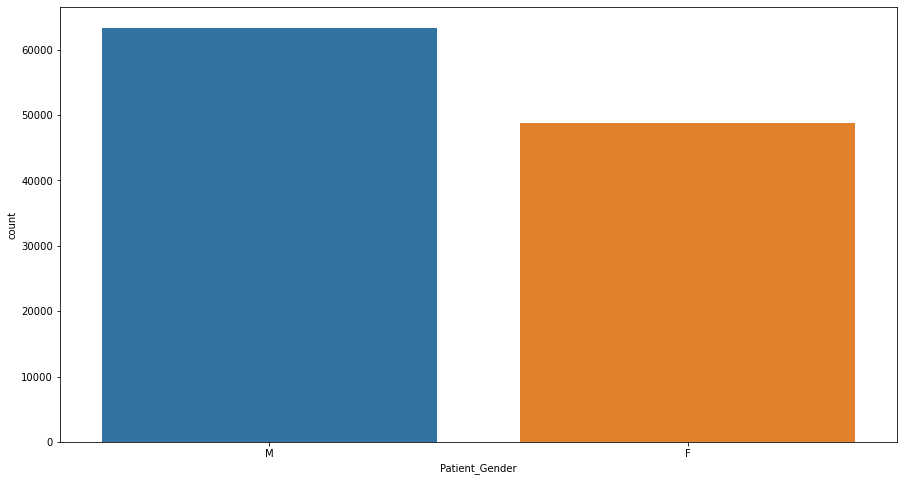

Male Patients: 63340
Female Patients: 48780


In [13]:
# Distribution of Patient Gender
plt.figure(figsize=(15,8))
sns.countplot(x='Patient_Gender', data=data)
plt.show()
male = len(list(filter(None, data.Patient_Gender == "M")))
female  = len(list(filter(None, data.Patient_Gender == "F")))
print("Male Patients:", male )
print("Female Patients:", female)

In [14]:
# Descriptives statistics of numerical variables
data.agg(
    {
        "Patient_Age": ["min", "max", "median", "mean", "std", "skew","count"],
        
    }
)

,Patient_Age
min,1.000000
max,414.000000
median,49.000000
mean,46.901463
std,16.839923
skew,0.289829
count,112120.000000


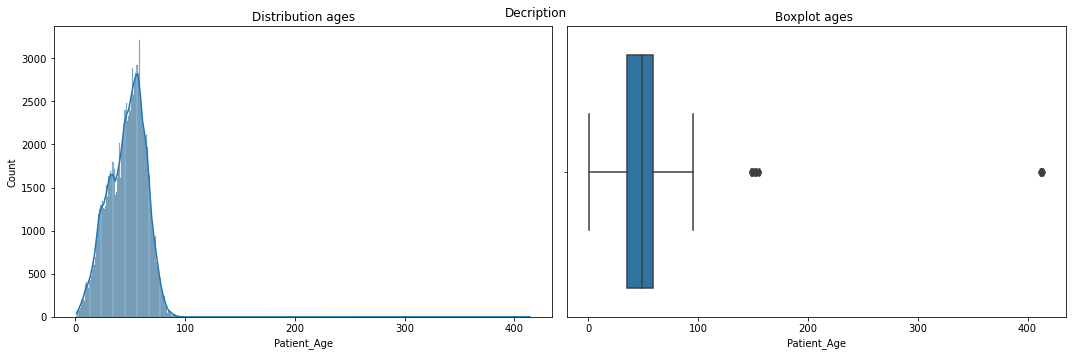

In [15]:
# Even seaborn is updated, you must restart kernel in order to take it in account 

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Decription')

sns.histplot(ax=axes[0], x='Patient_Age', data=data, kde=True)
axes[0].set_title("Distribution ages")

sns.boxplot(ax=axes[1], x='Patient_Age', data=data)
axes[1].set_title("Boxplot ages ")
plt.tight_layout()
plt.show()

Given the summary statistic, the distribution age variable and the Boxplot, it seems there's outliers.

Let's see how many patients aged more than 90 years old 

In [16]:
# List of patients ageed more than 90 
data[data.Patient_Age>90]

,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed:_11
230,00000049_000.png,Nodule,0,49,91,F,PA,2650,2465,0.143000,0.143000,NaN
231,00000049_001.png,No Finding,1,49,92,F,PA,2992,2991,0.143000,0.143000,NaN
576,00000143_000.png,No Finding,0,143,94,M,AP,3056,2544,0.139000,0.139000,NaN
577,00000143_001.png,No Finding,1,143,94,M,PA,2892,2894,0.143000,0.143000,NaN
578,00000143_002.png,Effusion|Infiltration,2,143,94,M,PA,2926,2322,0.143000,0.143000,NaN
581,00000143_005.png,No Finding,5,143,91,M,PA,2500,2048,0.168000,0.168000,NaN
583,00000143_007.png,No Finding,7,143,92,M,AP,2500,2048,0.168000,0.168000,NaN
584,00000143_008.png,Atelectasis,8,143,92,M,AP,2500,2048,0.168000,0.168000,NaN
585,00000143_009.png,Atelectasis,9,143,91,M,PA,2992,2991,0.143000,0.143000,NaN
586,00000143_010.png,No Finding,10,143,92,M,PA,2048,2500,0.168000,0.168000,NaN


In [17]:
len(data[data.Patient_Age>90])

51

We have 51 patients aged from 90 or older 

Let's see the distribution of age from 0 to 90 years old

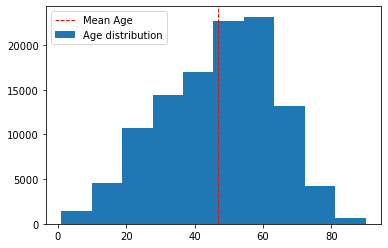

In [18]:
# Distribution Age from 0 to 90 years 
fig,ax = plt.subplots()

# Age from 0 to 90 years old 
df_age_0_90=data[data.Patient_Age<=90]

data_line = ax.hist(df_age_0_90['Patient_Age'], label='Age distribution')
plt.axvline(df_age_0_90['Patient_Age'].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean Age')
legend = ax.legend(loc='upper left')

plt.show()

The younger patients age thend to be around from 1 to 10 years old, then mean age is around 47 years with the median of 49

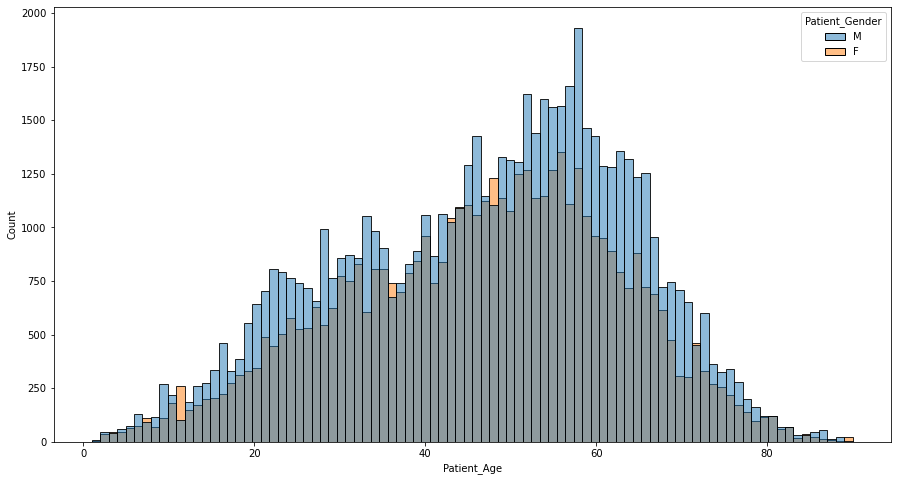

In [19]:
# Histplot check after 
## Age from 0 to 90 years old 
plt.figure(figsize=(15,8))
sns.histplot(df_age_0_90, x = "Patient_Age", hue="Patient_Gender")
plt.show()

###### Understand the case Distribution of variable Finding_Labels

In [20]:
data.head()

,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed:_11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [21]:
data.Finding_Labels.unique()

array(['Cardiomegaly', 'Cardiomegaly|Emphysema', 'Cardiomegaly|Effusion',
       'No Finding', 'Hernia', 'Hernia|Infiltration', 'Mass|Nodule',
       'Infiltration', 'Effusion|Infiltration', 'Nodule', 'Emphysema',
       'Effusion', 'Atelectasis', 'Effusion|Mass',
       'Emphysema|Pneumothorax', 'Pleural_Thickening',
       'Effusion|Emphysema|Infiltration|Pneumothorax',
       'Emphysema|Infiltration|Pleural_Thickening|Pneumothorax',
       'Effusion|Pneumonia|Pneumothorax', 'Pneumothorax',
       'Effusion|Infiltration|Pneumothorax', 'Infiltration|Mass',
       'Infiltration|Mass|Pneumothorax', 'Mass',
       'Cardiomegaly|Infiltration|Mass|Nodule',
       'Cardiomegaly|Effusion|Emphysema|Mass',
       'Atelectasis|Cardiomegaly|Emphysema|Mass|Pneumothorax',
       'Emphysema|Mass', 'Emphysema|Mass|Pneumothorax',
       'Atelectasis|Pneumothorax', 'Cardiomegaly|Emphysema|Pneumothorax',
       'Mass|Pleural_Thickening', 'Cardiomegaly|Mass|Pleural_Thickening',
       'Effusion|Infiltra

In [22]:
all_labels = np.unique(list(chain(*data['Finding_Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

In [23]:
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: 
        data[c_label] = data['Finding_Labels'].map(lambda finding: 1 if c_label in finding else 0)
data.head(1)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0


In [24]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [25]:
# Number of Pathologies 
len(all_labels)

15

We have 15 distincts pathologies in this dataset

[Text(0, 0.5, 'Number of Images with Label')]

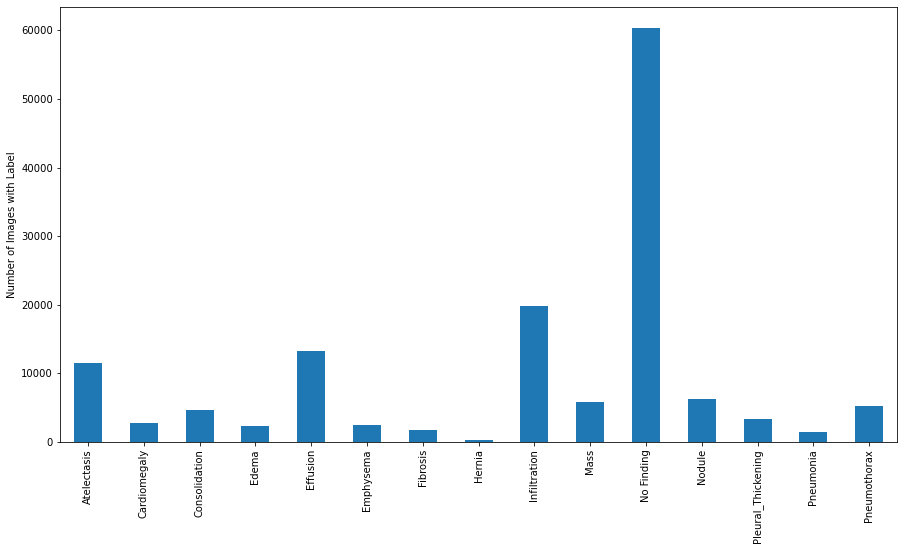

In [26]:
# Number of Images with Label
plt.figure(figsize=(15,8))
ax = data[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

###### The distribution of other diseases that are comorbid with pneumonia

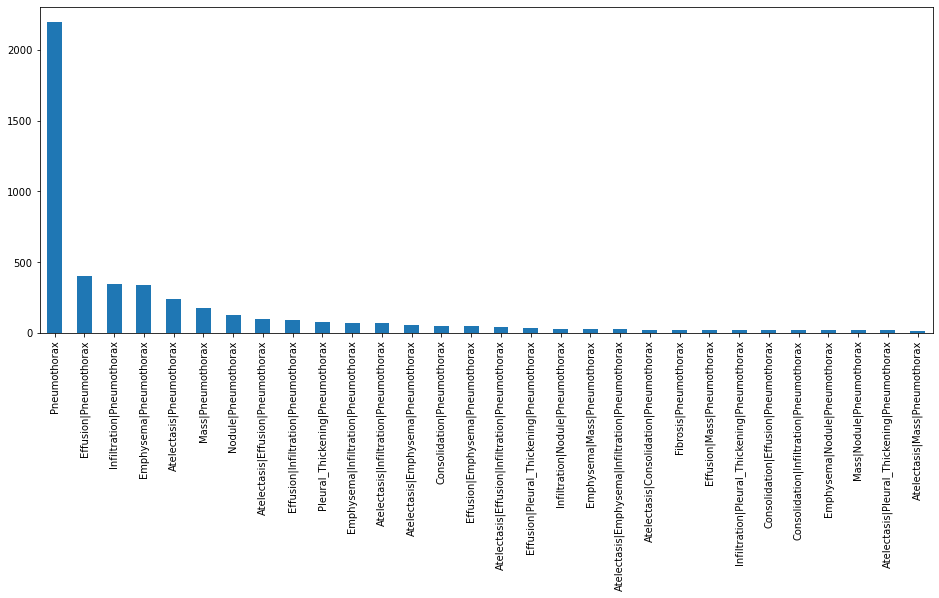

In [27]:
plt.figure(figsize=(16,6))
data[data.Pneumothorax==1]['Finding_Labels'].value_counts()[0:30].plot(kind='bar')

###### Gender distribution with Pneumothorax

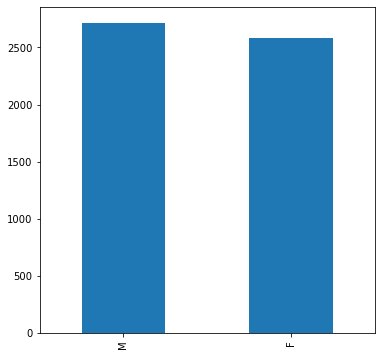

In [28]:
#Gender distribution with Pneumothorax¶
plt.figure(figsize=(6,6))
data[data.Pneumothorax ==1]['Patient_Gender'].value_counts().plot(kind='bar')
plt.show()

More male affected than famale

###### Gender distribution with Pneumonia

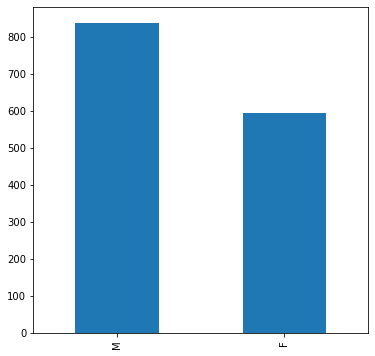

In [29]:
#Gender distribution with Pneumonia
plt.figure(figsize=(6,6))
data[data.Pneumonia ==1]['Patient_Gender'].value_counts().plot(kind='bar')
plt.show()

More Male affected than Famale 

###### Gender distribution with Cardiomegaly

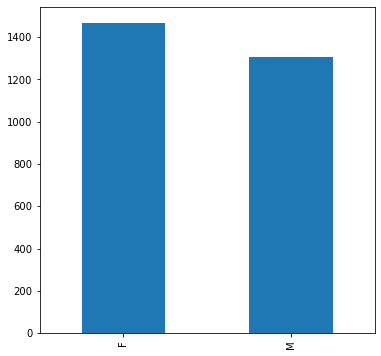

In [30]:
#Gender distribution with Cardiomegaly
plt.figure(figsize=(6,6))
data[data.Cardiomegaly ==1]['Patient_Gender'].value_counts().plot(kind='bar')
plt.show()

More famale affected than Male 

###### Number of disease per patient

In [31]:
data.sample(3)

,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
23801,00006277_001.png,Atelectasis|Infiltration,1,6277,68,M,AP,2500,2048,0.171,...,0,0,0,1,0,0,0,0,0,0
6711,00001805_003.png,Infiltration|Nodule|Pleural_Thickening,3,1805,41,M,PA,2350,2453,0.143,...,0,0,0,1,0,0,1,1,0,0
9507,00002469_002.png,No Finding,2,2469,63,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0


In [32]:
# Create a new df with all the patients where the Finding_Labels columns does not include "No Finding"
df_finding = data[['Patient_ID', 'Finding_Labels']].copy()
is_sick = df_finding['Finding_Labels'] != "No Finding"
df_finding = df_finding[is_sick]
df_finding["number_of_diseases"] = ""

for index, row in df_finding.iterrows():
    df_finding.at[index,'number_of_diseases'] = len(row['Finding_Labels'].split("|"))

df_finding.head()

,Patient_ID,Finding_Labels,number_of_diseases
0,1,Cardiomegaly,1
1,1,Cardiomegaly|Emphysema,2
2,1,Cardiomegaly|Effusion,2
4,3,Hernia,1
5,3,Hernia,1


In [33]:
print("There are ", df_finding.shape[0], " patients with at least a single finding left.")

There are  51759  patients with at least a single finding left.


In [34]:
# Create a dict to store the dieseases and the number of diseases per patient
# Patients can occur several times in the dataset, so we need to sum the findings per patient
dict_disease = {}
unique_patients = []
for index, row in df_finding.iterrows():
    patient_id = row["Patient_ID"]
    unique_patients.append(patient_id)
    if not patient_id in dict_disease:   
        dict_disease[patient_id] = []
    for e in row['Finding_Labels'].split("|"):
        dict_disease[patient_id].append(e)
    dict_disease[patient_id] =  dict_disease[patient_id]
    
for key, value in dict_disease.items():
    dict_disease[key] = {
        "diseases": set(value),
        "number_of_diseases": len(set(value))
    }

dict_disease[1]

{'diseases': {'Cardiomegaly', 'Effusion', 'Emphysema'},
 'number_of_diseases': 3}

In [35]:
print("There are", len(set(unique_patients)), "unique patients with at least one finding in the dataset")

There are 14402 unique patients with at least one finding in the dataset


In [37]:
# key = number of diseases
# value = number of patients
number_of_diseases = {}
for key, value in dict_disease.items():
    if not value["number_of_diseases"] in number_of_diseases:   
        number_of_diseases[value["number_of_diseases"]] = 0
    number_of_diseases[value["number_of_diseases"]] = number_of_diseases[value["number_of_diseases"]] + 1

number_of_diseases 

{3: 1638,
 2: 2908,
 1: 6742,
 10: 84,
 4: 1087,
 8: 205,
 5: 707,
 6: 518,
 7: 335,
 11: 28,
 9: 139,
 12: 7,
 13: 4}

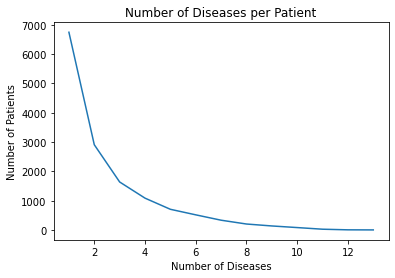

In [38]:
lists = sorted(number_of_diseases.items())
x, y = zip(*lists)
plt.plot(x, y)
plt.xlabel('Number of Diseases')
plt.ylabel('Number of Patients')
plt.title('Number of Diseases per Patient')
plt.show()

Many of the people in the database only have one ailment (6,740). The number of patients decreases as the number of results increases. It's interesting to note that seven patients have 12 results while three patients have 13 findings.

##### 2. The x-ray views taken (i.e. view position)

In [39]:
data.View_Position.unique()

array(['PA', 'AP'], dtype=object)

In [40]:
data.View_Position.value_counts()

PA    67310
AP    44810
Name: View_Position, dtype: int64

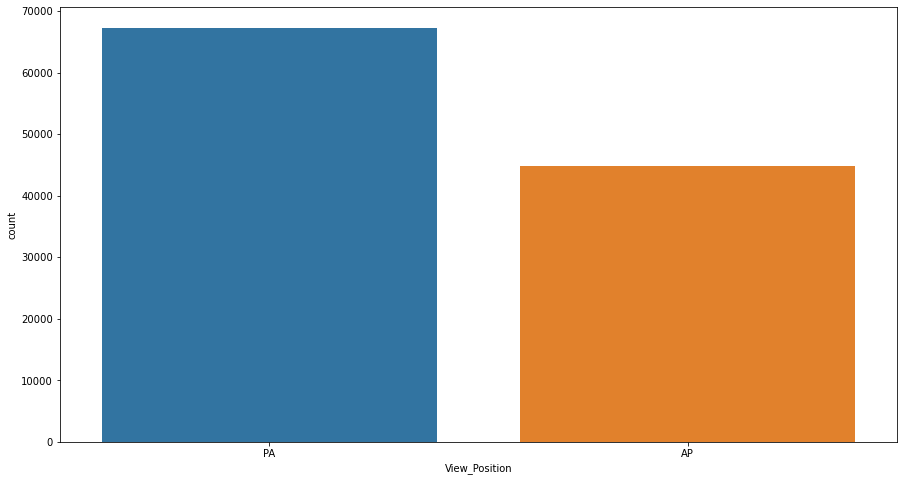

PA View Position:-  67310
AP View Positions: -  44810


In [41]:
plt.figure(figsize=(15,8))
sns.countplot(x='View_Position', data=data)
plt.show()
View_Position_pa = len(list(filter(None, data.View_Position == "PA")))
View_Position_ap  = len(list(filter(None, data.View_Position == "AP")))
print("PA View Position:- ", View_Position_pa )
print("AP View Positions: - ", View_Position_ap)

###### Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases

In [42]:
data.sample(2)

,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
95454,00025090_007.png,Atelectasis,7,25090,69,F,PA,2021,2021,0.194311,...,0,0,0,0,0,0,0,0,0,0
71857,00017709_013.png,No Finding,13,17709,27,M,PA,2992,2991,0.143000,...,0,0,0,0,0,1,0,0,0,0


In [43]:
# get the images from the patients
image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}

In [44]:
# First image
print(list(image_paths)[0])

00019124_042.png


###### Let's see what looks like the chest x-ray 

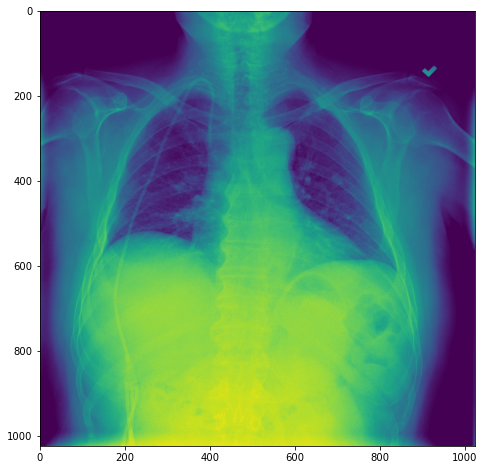

In [45]:
# Let's image what looks the chest x-rays 
plt.figure(figsize=(8,8))
image=data['Image_Index'].sample().item()
image=io.imread(image_paths[image])
plt.imshow(image)
plt.show()

###### A sample of image with cmap = grey

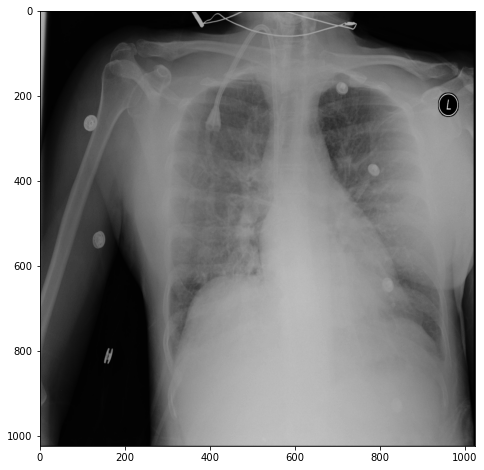

In [46]:
# cmap=gray 
plt.figure(figsize=(8,8))
image=data['Image_Index'].sample().item()
image=io.imread(image_paths[image])
plt.imshow(image, cmap='gray')
plt.show()

###### Example of Image Intensity Distribution without applying Normalization

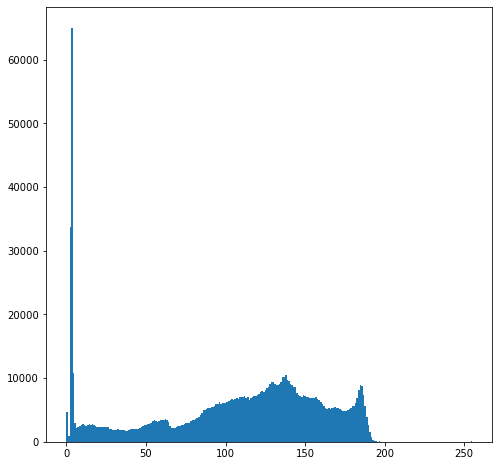

In [47]:
# Intensity Distribution without applying plt.figure(figsize=(10,10))
plt.figure(figsize=(8,8))
x = plt.hist(image.ravel(),bins=256)

##### Standardization and Intensity distribution Function

In [48]:
## Function standardize the image
def standardize_image(imageData):
    # Find the mean and std dev intensity values of the image, and standerdize it
    mean_intensity = np.mean(imageData)
    std_intensity = np.std(imageData)
    new_img = imageData.copy()
    new_img = (new_img - mean_intensity)/std_intensity
    return new_img

## Function to print the image and the intensity distribution
def distribution_image(image):
    f = plt.figure(figsize=(5,5))
    f.set_figwidth(15)
    
    # standardize the image data
    image = standardize_image(image)
    
    s1 = f.add_subplot(1, 2, 1,)
    s1.set_title('Image')
    plt.imshow(image, cmap='gray')
    
    s2 = f.add_subplot(1, 2, 2)
    s2.set_title('Intensity Distribution')
    plt.hist(image.ravel(), bins = 256)
    
    plt.show()

##### Chest image with Pneumonia and Intensity Distribution

Image Name 00002846_013.png


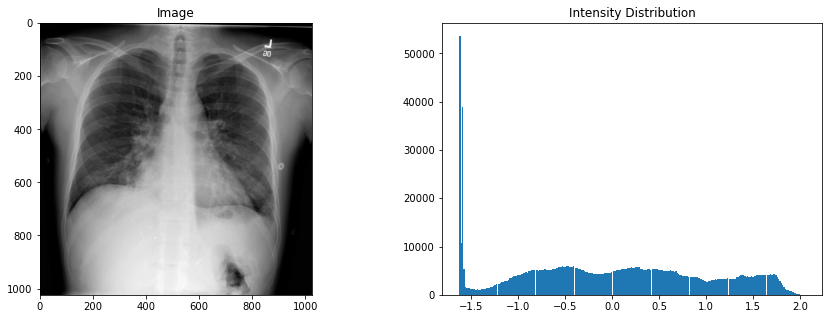

In [49]:
image = data[data['Pneumonia']==1]['Image_Index'].sample().item()
print('Image Name', image)
image = io.imread(image_paths[image])
distribution_image(image)

Image Name 00014520_008.png


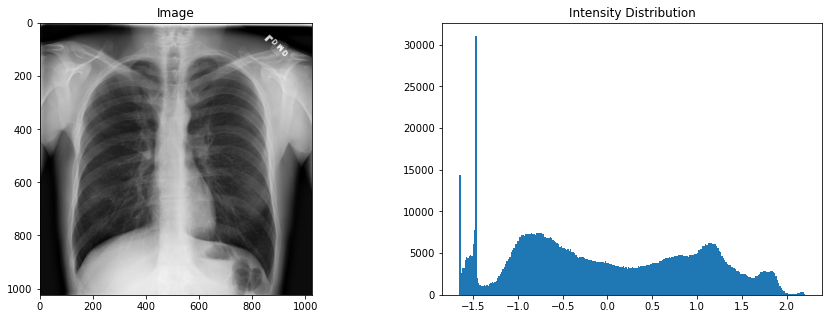

In [50]:
image = data[data['Pneumonia']==1]['Image_Index'].sample().item()
print('Image Name', image)
image = io.imread(image_paths[image])
distribution_image(image)

##### Chest without Pneumonia and Intensity Distribution

Image Name 00019775_000.png


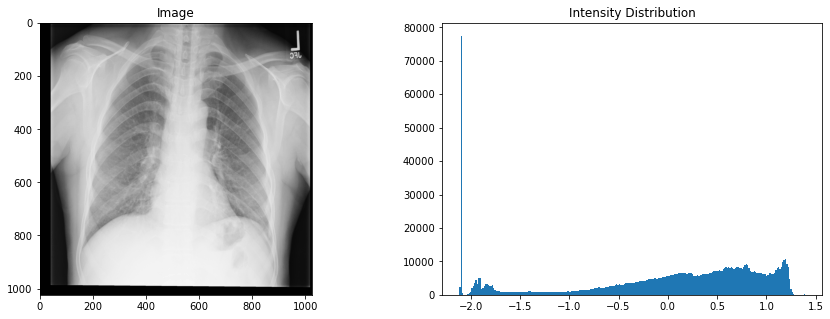

In [51]:
image = data[data['Pneumonia']==0]['Image_Index'].sample().item()
print('Image Name', image)
image = io.imread(image_paths[image])
distribution_image(image)

Image Name 00013386_005.png


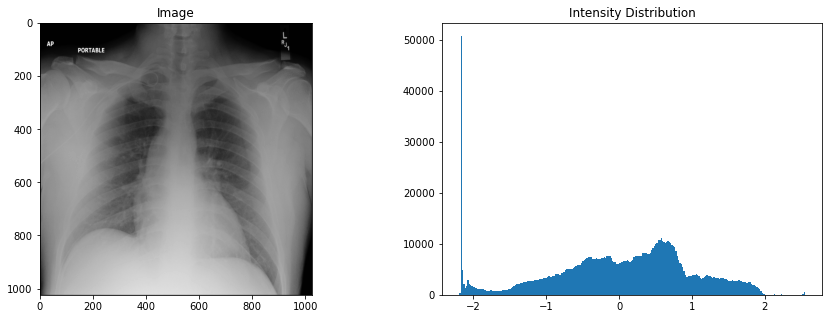

In [52]:
image = data[data['Pneumonia']==0]['Image_Index'].sample().item()
print('Image Name', image)
image = io.imread(image_paths[image])
distribution_image(image)

###### # Let's just look for the other disease also (For instance Cardiomegaly where there's more female affected)

Image Name 00012505_008.png


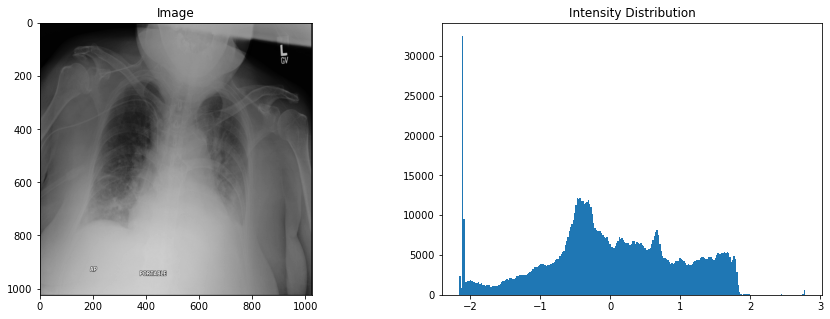

In [53]:
image = data[data['Cardiomegaly']==1]['Image_Index'].sample().item()
print('Image Name', image)
image = io.imread(image_paths[image])
distribution_image(image)

###### CONCLUSION

There are 112,120 chest x-rays with illness labels in the collection, which were collected from 30,000 individuals. These x-rays were taken from 63,340 men and 48,780 women. The ages vary from 1 to 90, The younger patients age thend to be around from 1 to 10 years old, then mean age is around 47 years with the median of 49.


"No Finding" is the most prevalent finding in the dataset, accounting for 54 percent of the total. With 18 percent of the vote, "Infiltration" is the second most popular finding. Pneumonia affects around 1% of all patients. Furthermore, Pneumonia is most commonly found alone. Infiltration is the most common co-occurrence with Pneumonia. Pneumonia with Infiltration and Edema is the third most common scenario. Pneumonia with Atelectasis is the fourth most common co-occurrence. Pneumonia with Edema is the fourth most prevalent condition. Pneumonia patients are not that dissimilar from the general population in terms of gender and age distribution.